In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import gspread
import pandas as pd
import numpy as np

In [2]:
from google.oauth2.service_account import Credentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('../google-secret.json', scopes=scope)
gs = gspread.authorize(credentials)

In [3]:
data_file = gs.open_by_url('https://docs.google.com/spreadsheets/d/1ierEhD6gcq51HAm433knjnVwey4ZE5DCnu1bW7PRG3E/edit?usp=sharing')
data_sheet = data_file.worksheet('Testy')

In [4]:
rows = data_sheet.get_all_values()
HEADER_ROW_idx = 1
NUM_COLUMNS = 15
df = pd.DataFrame(rows[HEADER_ROW_idx+1:]).T.iloc[1:NUM_COLUMNS].T
df.columns = rows[HEADER_ROW_idx][1:NUM_COLUMNS]

df = df[[u'Data', u'Liczba wykonanych testów', u'Osoby z wynikiem pozywnym']]
df.columns = ['Date', 'Total', 'Positive']

df = df.iloc[1:]

df.index = pd.to_datetime(df.Date.map(lambda d: '.'.join(d.split('.')[::-1]+['2020'])))
df = df.drop(columns=['Date'])
df.Total = pd.to_numeric(df.Total)
df.Positive = pd.to_numeric(df.Positive)
df['Negative'] = df.Total - df.Positive

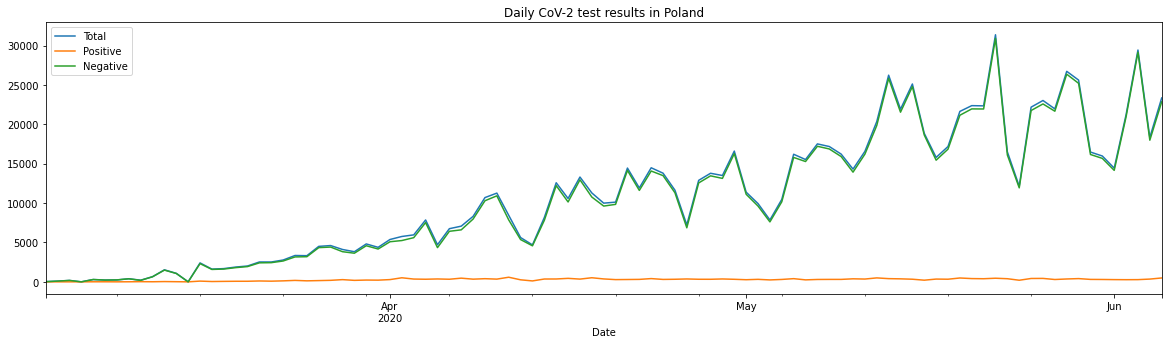

In [5]:
df.plot(figsize=(20,5), title='Daily CoV-2 test results in Poland');

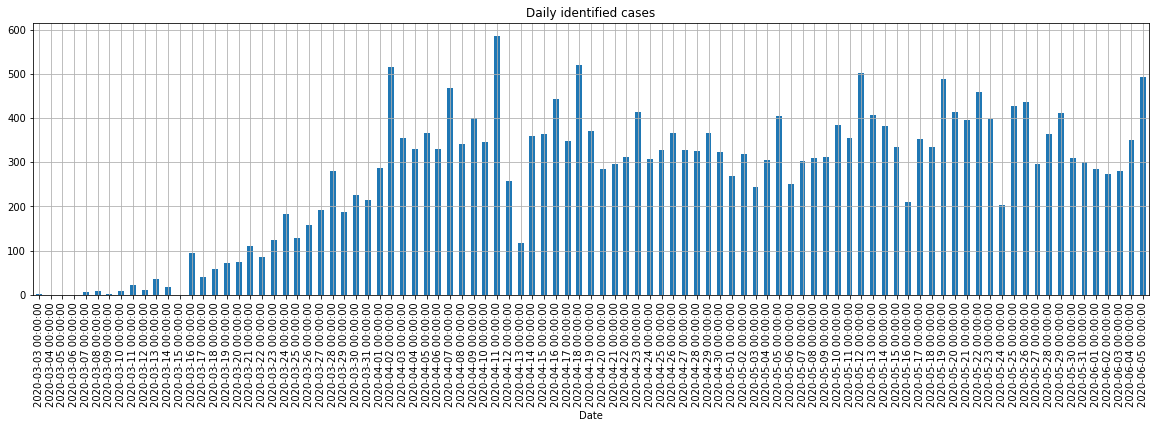

In [6]:
df.Positive.plot.bar(figsize=(20,5), title='Daily identified cases');
plt.grid(True);

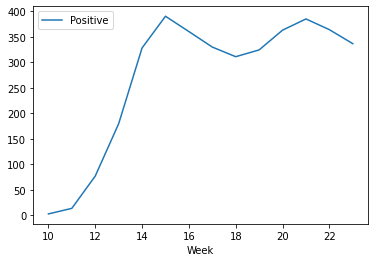

In [7]:
df['Week'] = df.index.week
df = pd.merge(left=df, right=df[['Positive', 'Week']].groupby('Week').mean().rename(columns={'Positive': 'WeeklyAvg'}), left_on='Week', right_index=True)
weekly = df[['Positive', 'Week']].groupby('Week').mean()
weekly.plot()

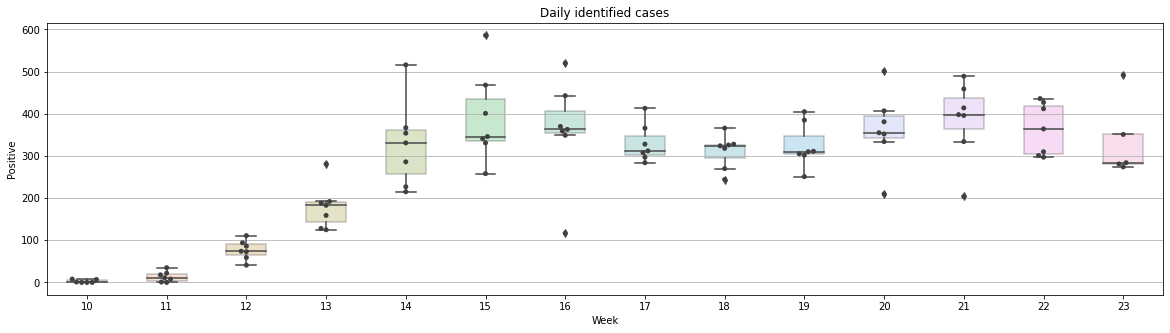

In [8]:
plt.figure(figsize=(20,5))
plt.title('Daily identified cases')
plt.grid(True)
sns.boxplot(ax=plt.gca(), x='Week', y='Positive', data=df, width=.5, boxprops=dict(alpha=.3));
sns.swarmplot(ax=plt.gca(), x='Week', y='Positive', data=df, color=".25");

(0.0, 600.0)

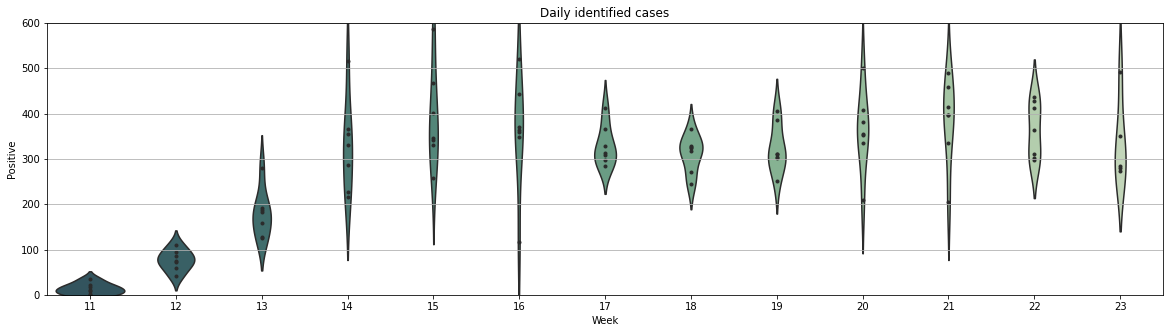

In [9]:
d = df[df.Week >= 11]
plt.figure(figsize=(20,5))
plt.title('Daily identified cases')
plt.grid(True)
pal = sns.cubehelix_palette(len(df.Week.unique()), rot=-.5, dark=.3, reverse=True)
sns.violinplot(ax=plt.gca(), x='Week', y='Positive', data=d, inner="points", palette=pal)
plt.ylim((0, 600))

# deltas over time

In [10]:
delta_sheet = data_file.worksheet('Wzrost')

In [11]:
rows = delta_sheet.get_all_values()
HEADER_ROW_idx = 1
df = pd.DataFrame(rows[HEADER_ROW_idx+1:]).T.iloc[:8].T
df.columns = rows[HEADER_ROW_idx][:8]

df = df[[u'Data', u'Nowe przypadki', u'Nowe zgony', u'Nowe wyzdrowienia']]
df.columns = ['Date', 'New', 'Deaths', 'Cured']

df = df.iloc[1:]

df.index = pd.to_datetime(df.Date.map(lambda d: '.'.join(d.split('.')[::-1]+['2020']) if d else np.nan))
df = df.loc[df.index.dropna()]
df = df.drop(columns=['Date'])
df.New = pd.to_numeric(df.New.map(lambda s: s.replace(' ', '')))
df.Deaths = -pd.to_numeric(df.Deaths.map(lambda s: s.replace(' ', '')))
df.Cured = -pd.to_numeric(df.Cured.map(lambda s: s.replace(' ', '')))

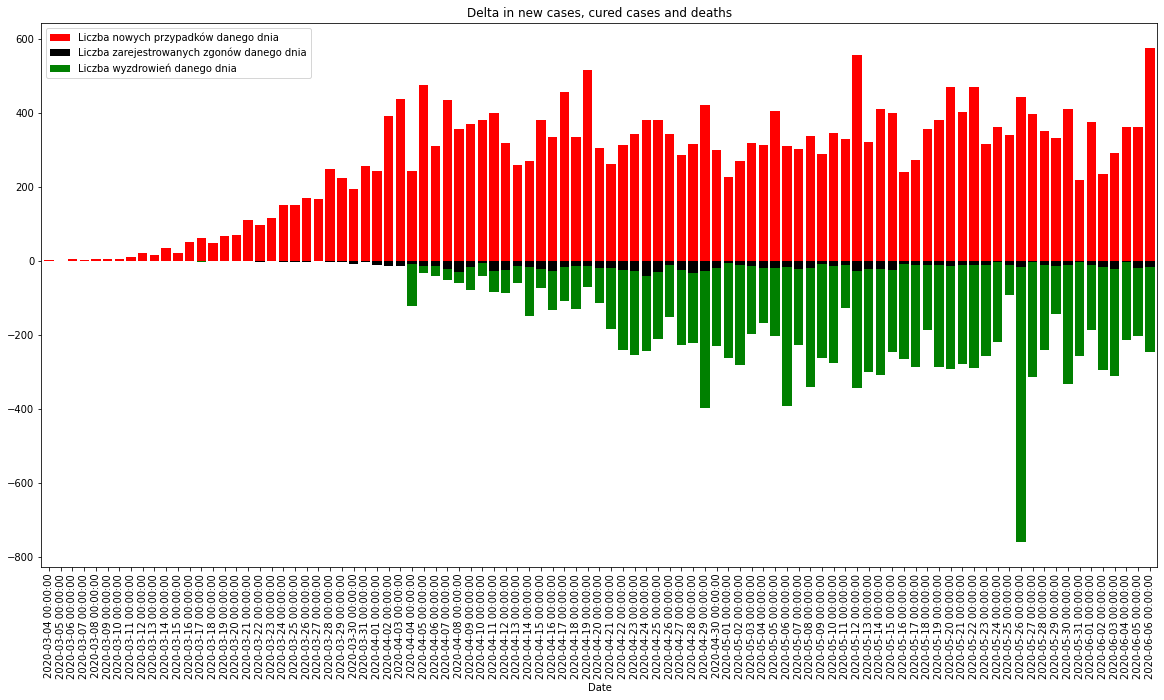

In [12]:
plt.figure(figsize=(20, 10))
plt.title('Delta in new cases, cured cases and deaths')
df.New.plot.bar(ax=plt.gca(), width=.8, color='r');
df[['Deaths', 'Cured']].plot.bar(ax=plt.gca(), stacked=True, width=.8, color=['k','g']);
plt.legend([u'Liczba nowych przypadków danego dnia', 
            u'Liczba zarejestrowanych zgonów danego dnia', 
            u'Liczba wyzdrowień danego dnia']);

In [13]:
def calc_percentages(df):
    df['All'] = df.New - df.Cured - df.Deaths
    df['NewPercent'] = df.New / df.All * 100.
    df['DeathsPercent'] = -df.Deaths / df.All * 100.
    df['CuredPercent'] = -df.Cured / df.All * 100.
    
calc_percentages(df)

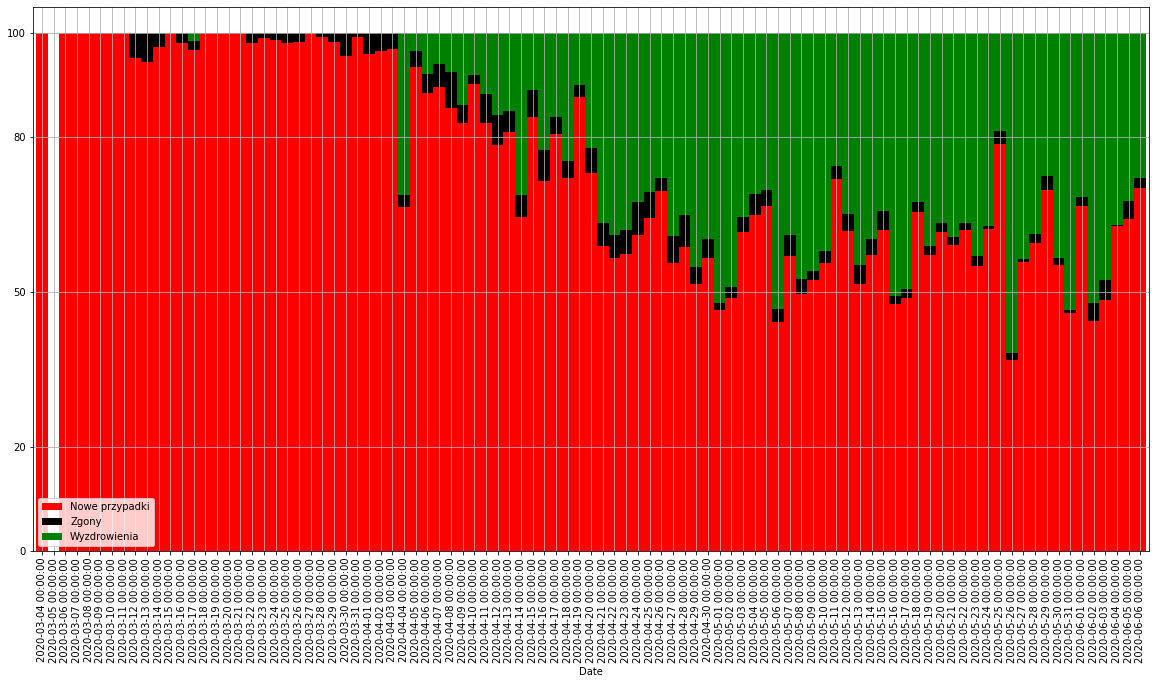

In [14]:
def plot_percentage_cases(df, bar_width=1.):
    plt.figure(figsize=(20, 10))
    df[['NewPercent', 'DeathsPercent', 'CuredPercent']].plot.bar(ax=plt.gca(), stacked=True, width=bar_width, color=['r', 'k','g'])
    plt.gca().set_yticks([0, 20, 50, 80, 100])
    plt.grid(True)
    plt.legend([u'Nowe przypadki', 
                u'Zgony', 
                u'Wyzdrowienia'], 
               loc='lower left');
    
    
plot_percentage_cases(df)

### ...weekly

In [15]:
if 'Week' in df.columns:
    del df['Week']
df['Week'] = df.index.week

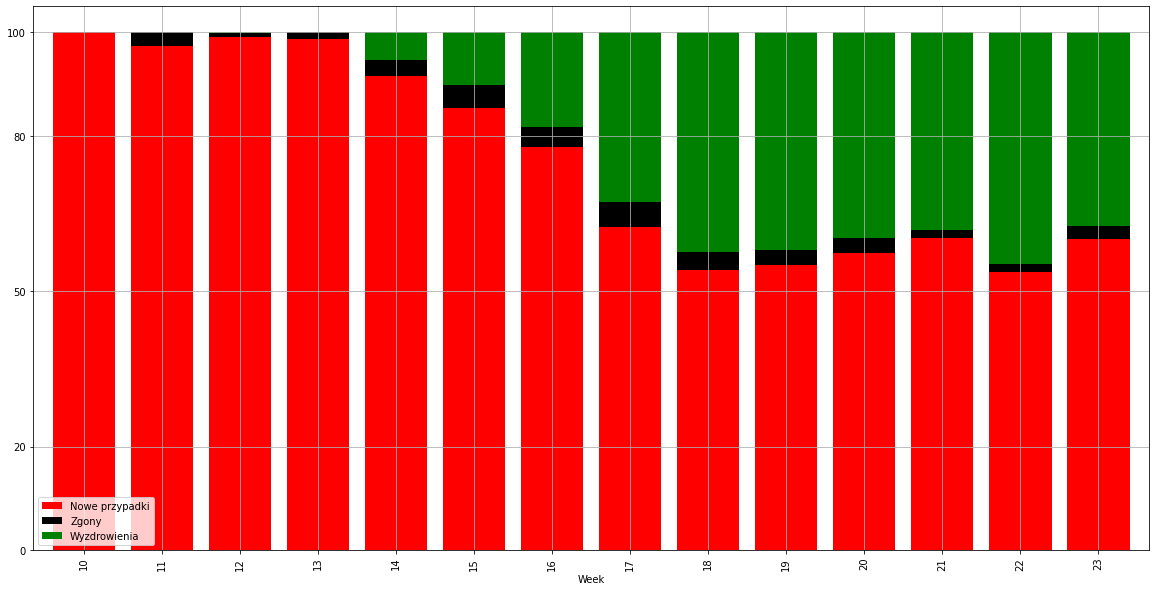

In [16]:
df_weekly = df[['New', 'Deaths', 'Cured', 'Week']].groupby('Week').sum()

calc_percentages(df_weekly)
plot_percentage_cases(df_weekly, 0.8)